In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dejong = lambda x: np.sum(x**2)
rastrigin = lambda x: 10*len(x) + np.sum( x**2 - 10 * np.cos(2*np.pi*x) )
rastrigin = lambda x: 10*len(x) + np.sum( np.array(x)**2 - 10 * np.cos(2*np.pi*np.array(x)) )
ackley = lambda x: -20. * np.exp(-1/5 * np.sqrt(1/len(x) * np.sum(np.power(x,2)))) - np.exp(1/len(x) * np.sum(np.cos(2*np.pi*x))) + 20. + np.e

In [3]:
from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt

def innovative_gunner(obj_func, xmin, xmax, alpha_max = np.pi/2, beta_max = np.pi/2, num_dimensions = 1, num_iterations = 10, popsize = 10, angle_adjuster=None, r=None):
    """
    Performs Innovative Gunner Algorithm (AIG) on specified obj_func function:

    Args:
        obj_func: Objective function to minimize
        xmin: Minimum value allowed for x 
        xmax: Maximum value allowed for x
        alpha_max: Controls the allowed value for random alpha angle in angle adjustements: alpha is random <-alpha-max ; alpha_max > with normal distribution where sigma = alpha_max/3
        beta_max: Controls the allowed value for random beta angle in angle adjustements: beta is random <-beta-max ; beta_max > with normal distribution where sigma = beta_max/3
        num_dimensions: Number of objective function dimensions
        num_iterations: Number of iterations = Number of salvos
        popsize: Size of population = Number of gunners
        angle_adjuster: String used to choose angle adjuster. Allowed values 'geometric', 'exponential', 'linear'. Custom can be used by assigning a callable to this parameter. Passed arguments are (angle,iter)
        r: r-value to use in exponential angle adjuster. Defaults to 1/(num_dimentions*num_iterations) if set to None
    """
    
    #Initialize variables
    x = np.empty([popsize,num_dimensions])
    obj_sum_values = []
    obj_min_values = []
    pops = []

    def g(angle):
        angle = np.deg2rad(angle)
        if angle>0:
            return 1/np.cos(angle)
        else:
            return np.cos(angle)

    match angle_adjuster:
        case None:
            def angle_adjuster(angle, iter): return angle
        case 'geometric':
            coef = 0.97 #decrease coefficient
            def angle_adjuster(angle, iter): return (angle * np.power(coef,iter)) + 1e-100
        case 'exponential':
            if (r==None):
                r = 1/(num_dimensions*num_iterations)
            def angle_adjuster(angle, iter): return (angle * np.exp(-iter*1*r)) + 1e-100
        case 'linear':
            amin = 0 #minimum value for angle
            def angle_adjuster(angle, iter): return (angle + (-iter) * (angle-amin)/num_iterations) + 1e-10
        case _:
            print("WARNING: Using custom defined angle adjuster with parameters (angle, iter)")



    #Random initialization of gun angles
    for i in range(popsize):
        if (num_dimensions > 1):
            for j in range(num_dimensions):
                x[i][j] = xmin + np.random.normal() * (xmax-xmin)
        else:
            x[i] = xmin + np.random.normal() * (xmax-xmin)
    pops.append(x.copy())
    
    #First evaluation = observe where shell lands
    y = [obj_func(np.array(x[i])) for i in range(popsize)]
    obj_min = np.min(y)
    obj_minarg = x[np.argmin(y)]

    for iter in range(num_iterations):
        #Modify x = adjust gun angles
        for pos, val in np.ndenumerate(x):
            #Calculate decreased angles
            alpha_dec = angle_adjuster(alpha_max, iter)
            beta_dec = angle_adjuster(beta_max, iter)

            #Get random new angles
            alpha = truncnorm.rvs((-alpha_dec)/(alpha_dec/3), alpha_dec/(alpha_dec/3), loc=0, scale= alpha_dec/3)
            beta = truncnorm.rvs((-beta_dec)/(beta_dec/3), beta_dec/(beta_dec/3), loc=0, scale= beta_dec/3)

            #Calculate new value and cut to bounds
            new_val = val * g(alpha) * g(beta)
            if new_val < xmin:
                new_val = xmin
            elif new_val > xmax:
                new_val = xmax
            x[pos] = new_val

        #Evaluate population = fire and observe
        y = [obj_func(np.array(x[i])) for i in range(popsize)]
        iter_obj_min = np.min(y)

        #Save new best results
        if (iter_obj_min < obj_min):
            obj_min = iter_obj_min
            obj_minarg = x[np.argmin(y)]

        #Save data for visualizations
        obj_sum_values.append(np.sum(y))
        obj_min_values.append(obj_min)  
        pops.append(x.copy())

    return obj_minarg, obj_min, obj_sum_values, obj_min_values, pops

Najlepszy wynik to 3.658224934267062


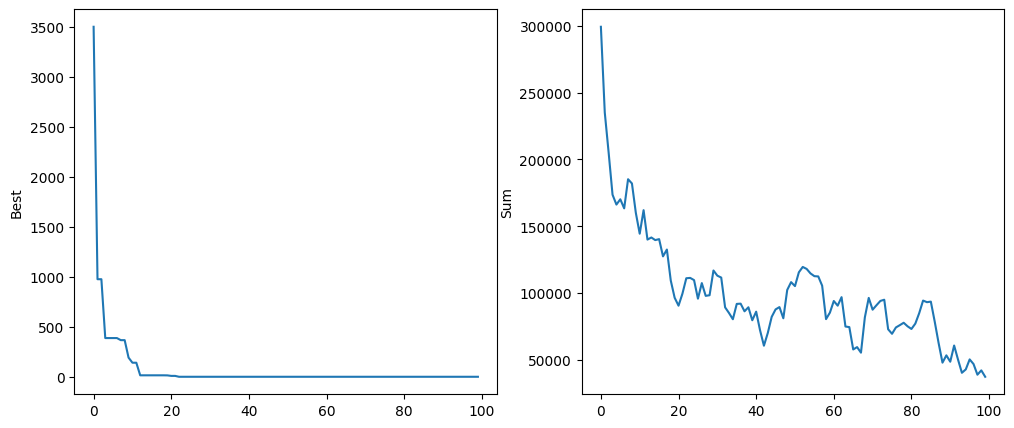

In [4]:
funcs = [dejong, rastrigin, ackley]
lims = [100., 5.12, 32.768]

id = 0
func = funcs[id]
xmax = lims[id]
xmin = -xmax

func = lambda x: funcs[id](x-2)

alpha_max = 90
beta_max = 90

angle_adjuster = 'linear'
angle_adjuster = None

ndims = 2
niter = 100
popsize = 20


obj_minarg, obj_min, sum_vals, best_vals, pops = innovative_gunner(func, xmin, xmax, num_dimensions=ndims, num_iterations=niter, popsize=popsize, alpha_max=alpha_max, beta_max=beta_max, angle_adjuster=angle_adjuster)
print(f"Najlepszy wynik to {obj_min}")

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(best_vals)
axs[1].plot(sum_vals)
axs[0].set_ylabel('Best')
axs[1].set_ylabel('Sum')
plt.show()